# Tutorial to evaluate models

In this tutorial we present two ways to evaluate your models. 

## Evaluating from a list of model predictions CSVs

Another useful option is to save the model predictions as a CSV and compute the factor accuracies and error ratios directly from those to easily compare them. Model predictions should be stored as a CSV with 3 columns, file_name, predicted_class and predicted_probability. (See next cell)

In [4]:
from imagenet_x import load_model_predictions


models_predictions, top_1_accs = load_model_predictions('../model_predictions/base')

models_predictions['DINO'].head()

,predicted_class,predicted_probability
file_name,,
ILSVRC2012_val_00000293.JPEG,0,0.634764
ILSVRC2012_val_00002138.JPEG,391,0.360206
ILSVRC2012_val_00003014.JPEG,0,0.951837
ILSVRC2012_val_00006697.JPEG,0,0.999731
ILSVRC2012_val_00007197.JPEG,0,0.998473


In [1]:
from imagenet_x import get_factor_accuracies, error_ratio

factor_accs = get_factor_accuracies('../model_predictions/base')
error_ratio = error_ratio(factor_accs)

display(factor_accs)
display(error_ratio)

,pose,background,pattern,color,smaller,shape,partial_view,subcategory,texture,larger,darker,object_blocking,person_blocking,style,brighter,multiple_objects,worst_factor,average
model,,,,,,,,,,,,,,,,,,
DINO,0.821561,0.737577,0.772103,0.710569,0.620690,0.596465,0.722571,0.519658,0.471631,0.693333,0.639344,0.525641,0.500000,0.581395,0.772727,0.650,0.471631,0.754283
ResNet50,0.824018,0.710799,0.804588,0.698862,0.620690,0.558174,0.713166,0.466667,0.393617,0.666667,0.565574,0.512821,0.450000,0.511628,0.704545,0.500,0.393617,0.746693
SimCLR,0.739976,0.634940,0.693905,0.623902,0.482069,0.505155,0.659875,0.456410,0.308511,0.660000,0.622951,0.410256,0.316667,0.604651,0.704545,0.600,0.308511,0.664064
ViT,0.827868,0.746458,0.799565,0.732358,0.617931,0.642121,0.786834,0.531624,0.524823,0.700000,0.573770,0.538462,0.550000,0.627907,0.818182,0.625,0.524823,0.767599


,pose,background,pattern,color,smaller,shape,partial_view,subcategory,texture,larger,darker,object_blocking,person_blocking,style,brighter,multiple_objects
model,,,,,,,,,,,,,,,,
DINO,0.726197,1.067989,0.927478,1.177905,1.543689,1.642275,1.129062,1.954860,2.150316,1.248049,1.467770,1.930511,2.034863,1.703606,0.924938,1.424404
ResNet50,0.694739,1.141699,0.771442,1.188826,1.497432,1.744230,1.132355,2.105479,2.393863,1.315925,1.715017,1.923274,2.171276,1.927983,1.166388,1.973887
SimCLR,0.774029,1.086696,0.911171,1.119552,1.541756,1.473035,1.012471,1.618136,2.058397,1.012098,1.122385,1.755525,2.034119,1.176858,0.879497,1.190704
ViT,0.740670,1.090969,0.862456,1.151641,1.644009,1.539923,0.917235,2.015381,2.044646,1.290873,1.834028,1.985959,1.936310,1.601083,0.782348,1.613592


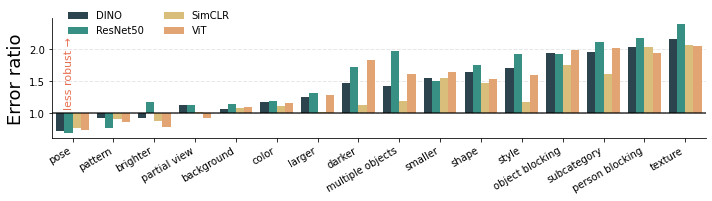

In [3]:
from imagenet_x import plots

plots.set_color_palette()
plots.model_comparison(factor_accs.reset_index())

## Evaluating directly using ImageNetX pytorch dataset

To evaluate directly during training, the best option is to use the ImageNetX pytorch dataset

Evaluating on Imagenet-X:   0%|          | 0/181 [00:00<?, ?it/s]

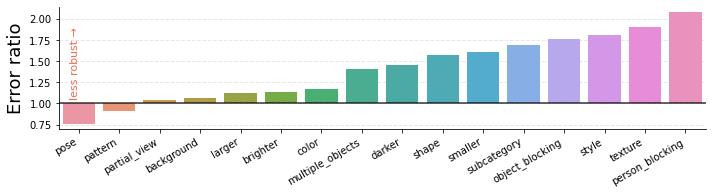

In [1]:
# imports
import matplotlib.pyplot as plt
import pandas as pd
import torch

from torchvision.models import ResNet18_Weights, resnet18
from tqdm.notebook import tqdm

from imagenet_x.evaluate import ImageNetX, get_vanilla_transform
from imagenet_x import FACTORS, plots

# Declare dataset
imagenet_val_path = '/datasets01/imagenet_full_size/061417/val/'
transforms = get_vanilla_transform()
dataset = ImageNetX(imagenet_val_path, transform=transforms)

# Load the model
model = resnet18(weights=ResNet18_Weights.DEFAULT)
device = 0
batch_size = 256
num_workers = 8

# Evaluate model on ImageNetX using simple loop
model.eval()
model.to(device)
loader = torch.utils.data.DataLoader(
    dataset,
    batch_size=batch_size,
    num_workers=num_workers,
    pin_memory=True,
)

correct = 0
total = 0
with torch.no_grad():
    for data, target, annotations in tqdm(loader, desc="Evaluating on Imagenet-X"):
        data, target = data.to(device), target.to(device)
        output = model(data)
        pred = output.argmax(dim=1)
        mask = pred.eq(target.view_as(pred))
        correct += annotations[mask,:].to(dtype=torch.int).sum(dim=0)
        total += annotations.to(dtype=torch.int).sum(dim=0)
        
# Compute accuracies per factor
factor_accs = (correct/total).cpu().detach().numpy()
results = pd.DataFrame({'Factor': FACTORS, 'acc': factor_accs}).sort_values('acc', ascending=False)

# Compute error ratios per factor
results['Error ratio'] = (1 - results['acc']) / (1-(correct.sum()/total.sum()).item())

# Plot results
plots.plot_bar_plot(results, x='Factor', y='Error ratio')
plt.show()